# Mapping Brain Atlas to Brain Images

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from PIL import Image

In [2]:
def plot_circles(img):
    """return coordinates of circle centers is circles detected in img
    """
    img=img.copy()
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    circles = cv2.HoughCircles(img_gray,cv2.HOUGH_GRADIENT,1,1,
                            param1=50,param2=30,minRadius=0,maxRadius=10)
    try:
        print(circles.shape)
    except AttributeError:
        print('No circles found')
        return
    print('{} coordinate array'.format(circles[0,:].shape))
    circles = np.uint16(np.around(circles))
    for i in circles[0,:]:
        # draw the outer circle
        cv2.circle(img,(i[0],i[1]),i[2],(0,255,0),2)
        # draw the center of the circle
        cv2.circle(img,(i[0],i[1]),2,(0,0,255),3)

    plt.imshow(img)
    circles = circles[0][:,0:2]
    i_coord, j_coord = [], []
    for i in circles:
        j_coord.append(i[0])
        i_coord.append(i[1])
    return np.array([tuple(i_coord), tuple(j_coord)])

# Detect Crosshairs

In [3]:
def crosshair_img():
    """Extract crosshair shape from sample image
    """
    img4 = cv2.imread('dongsheng-imaging/crosshair_crop.png') 
    img = img4.copy()[5:20, 6:21]
    plt.imshow(img)
    img[0:7, 0:7] = 0
    plt.imshow(img)
    img[0:7, 8:17] = 0
    plt.imshow(img)
    img[8:17, 0:7] = 0
    plt.imshow(img)
    img[8:17, 8:17] = 0
    plt.imshow(img)
    img = np.select([img!=0, img==0], [1, 0])
    plt.imshow(img)
    plt.imsave('dongsheng-imaging/crosshair.png', img)

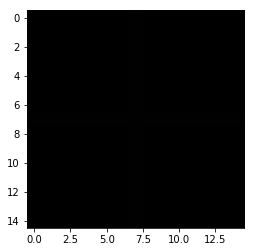

In [4]:
crosshair_img() # produce the crosshair image

In [5]:
def crosshair_coordinates(image='dongsheng-imaging/brain_image.png', crosshair='dongsheng-imaging/crosshair.png'):
    """return coordinates of crosshair centers
    """
    crosshair = cv2.imread(crosshair)[:,:,0]
    imagegrey = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
    image = cv2.imread(image)
    diff = (imagegrey - image[:,:,0])
    masked_diff = np.select([diff!=0, diff==0], [1, np.nan])
    
    # locate crosshairs
    found_i = []
    found_j = []
    foundbox = False
    for i in range(7, 121):
        for j in range(7, 121):
            truthy = (masked_diff[i-7:i+8, j-7:j+8] == crosshair)
            checksum = masked_diff[i-7:i+8, j-7:j+8][truthy].sum()
            if checksum>=29:
                found_i.append(i)
                found_j.append(j)
                
    # locate central crosshair
    a = np.zeros([128,128])
    a[tuple(found_i), tuple(found_j)] = 1
    b = np.array([
        [1,1,1],
        [1,1,1],
        [1,1,1]
        ])
    box_i = []
    box_j = []
    for i in range(1, 128):
        for j in range(1, 128):
            truthy = a[i-1:i+2, j-1:j+2] == b
            try:
                if truthy.all():
                    box_i.append(i)
                    box_j.append(j)
            except:
                pass
    return np.array([tuple(box_i), tuple(box_j)])

# Correlate points and confirm

In [6]:
icoord, jcoord = crosshair_coordinates()

/home/valykrie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


(1, 4, 3)
(4, 3) coordinate array


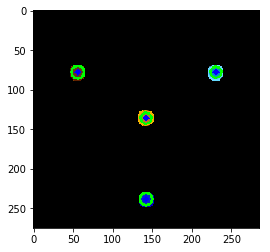

In [8]:
imask, jmask = plot_circles(cv2.imread('dongsheng-imaging/atlaslabelled.png'))
jmask = (jmask[2], jmask[0], jmask[1], jmask[3])
imask = (imask[2], imask[0], imask[1], imask[3])

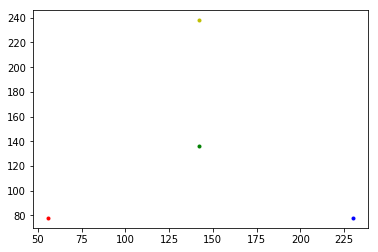

In [9]:
for a, color in enumerate( ['r.', 'b.', 'g.', 'y.']):
    plt.plot(jmask[a], imask[a], color)

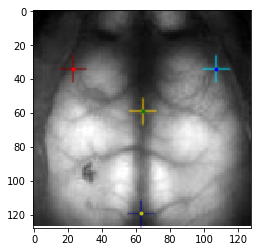

In [10]:
plt.imshow(cv2.imread('dongsheng-imaging/brain_image.png'))
for a, color in enumerate( ['r.', 'b.', 'g.', 'y.']):
    plt.plot(jcoord[a], icoord[a], color)

## Apply Affine Transformation

In [11]:
pts1,pts2 = [], []
for i in [0,1,3]:
    pts1.append([jmask[i], imask[i]])
    pts2.append([jcoord[i], icoord[i]])
pts1, pts2 = np.asarray(pts1).astype('float32'), np.asarray(pts2).astype('float32') # input, ouput

In [12]:
im = Image.open('dongsheng-imaging/atlaslabelled.png')
im = np.array(im)

(<matplotlib.axes._subplots.AxesSubplot at 0x7efcb92cc7b8>,
 Text(0.5, 1.0, 'Output'))

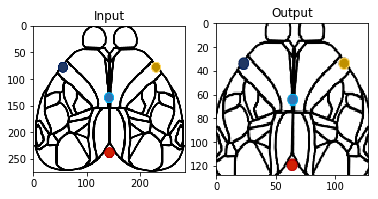

In [13]:
rows,cols,ch = im.shape
M = cv2.getAffineTransform(pts1,pts2)
dst = cv2.warpAffine(im,M,(cols,rows))[0:128,0:128]
plt.subplot(121),plt.imshow(im),plt.title('Input')
plt.subplot(122),plt.imshow(dst),plt.title('Output')

# Overlay transformed map onto brain image

In [14]:
brain = cv2.imread('dongsheng-imaging/brain_image.png')
brain_bw = np.expand_dims(cv2.cvtColor(brain,  cv2.COLOR_BGR2GRAY), axis = -1)

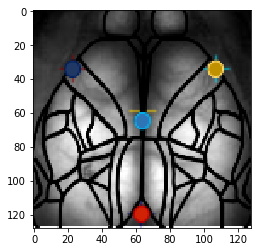

In [15]:
plt.imshow(brain)
plt.imshow(dst)